# Gaussian Mixture Models (GMMs)

**Gaussian Mixture Models (GMMs)** are statistical models that represent the data as a mixture of Gaussian (normal) distributions. These models can be used to identify groups within the dataset, and to capture the complex, multi-modal structure of data distributions.

*GMMs are used in a variety of machine learning applications, including clustering, density estimation, and pattern recognition.*

<div style="align:center">
    <img src="media/GMM.png" width=300>
</div>

## Mixture Models

<hr>
A **mixture model** is a probability model for representing data that may arise from several different sources or categories, each of which is modeled by a separate probability distribution. For example, financial returns typically behave differently under normal market conditions and during periods of crisis, and thus can be modeled as a mixture of two distinct distributions.

Formally, if $X$ is a random variable whose distribution is a mixture of $K$ component distributions, the probability density function (PDF) or probability mass function (PMF) of $X$ can be written as:

$$p(x) = \sum_{k=1}^K w_k f_k (x; \theta_k)$$

where:
- $p(x)$ is the overall density or mass function of the mixture model.
- $K$ is the number of component distributions in the mixture.
- $f_k (x; \theta_k)$ is the density or mass function of the $k$th component distribution, parametrized by $\theta_k$.
- $w_k$ is the mixing weight of the $k$th component, with $0 \leq w_k \leq 1$ and the sum of the weights being $1$. $w_k$ is also known as the prior probability of component $k$.
- $\theta_k$ represents the parameters of the $k$th component, such as the mean and standard deviation in the case of Gaussian distributions.

The mixture model assumes that each data point comes from one of the $K$ component distributions, with the specific distribution being selected according to the mixing weights $w_k$. The model does not require knowing which component each data point belongs to.

A **Gaussian mixture model (GMM)** is a common mixture model, where the probability density is given by a mixture of Gaussian distributions:

$$p(x) = \sum_{k=1}^K w_k N(x; \mu_k, \Sigma_k)$$

where:
- $x$ is a $d$-dimensional vector.
- $\mu_k$ is the mean vector of the $k$th Gaussian component.
- $\Sigma_k$ is the covariance matrix of the $k$th Gaussian component.
- $N(x; \mu_k, \Sigma_k)$ is the multivariate normal density function for the $k$th component:

$$N(x; \mu_k, \Sigma_k) = \frac{1}{\sqrt{(2\pi)^d |\Sigma_k|}} \text{exp} \left(\frac{1}{2} (x-\mu_k)^T \Sigma_{k}^{-1} (x-\mu_k)\right)$$

In the case of univariate Gaussian distributions, the probability density can be simplified to:

$$p(x) = \sum_{k=1}^K w_k N(x; \mu_k, \sigma_k)$$

where:
- $\mu_k$ is the mean of the $k$th Gaussian component.
- $\sigma_k$ is the covariance matrix of the $k$th Gaussian component.
- $N(x; \mu_k, \sigma_k)$ is the univariate normal density function for the $k$th component:

$$N(x; \mu_k, \sigma_k) = \frac{1}{\sqrt{2\pi} \sigma_k} \text{exp} (- \frac{(x-\mu_k)^2}{2\sigma_{k}^2})$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

In [2]:
def plot_mixture(mean1, std1, mean2, std2, w1, w2):
    # Generate points for the x-axis
    x = np.linspace(-5, 10, 1000)
    
    # Calculate the individual normal distributions
    normal1 = norm.pdf(x, mean1, std1)
    normal2 = norm.pdf(x, mean2, std2)
    
    # Calculate the mixture
    mixture = w1 * normal1 + w2 * normal2
    
    # Plot the results
    plt.plot(x, normal1, label='Normal distribution 1', linestyle='--')
    plt.plot(x, normal2, label='Normal distribution 2', linestyle='--')
    plt.plot(x, mixture, label='Mixture model', color='black')
    plt.xlabel('$x$')
    plt.ylabel('$p(x)$')
    plt.legend()

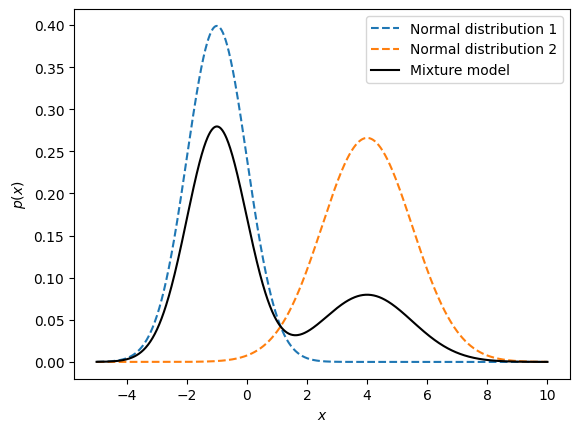

In [3]:
# Parameters for the two univariate normal distributions
mean1, std1 = -1, 1
mean2, std2 = 4, 1.5
w1, w2 = 0.7, 0.3

plot_mixture(mean1, std1, mean2, std2, w1, w2)

## Learning the GMM Parameters

<hr>

Our goal is to find the parameters of the GMM (means, covariances, and mixing coefficients) that will best explain the observed data. To that end, we first define the likelihood of the model given the input data.

For a GMM with $K$ components and a dataset $X = \{x_1, \cdots, x_n\}$ of $n$ data points, the likelihood function $L$ is given by the product of the probability densities of each data point, as defined by the GMM:

$$\mathcal{L}(\theta \mid X) = \prod_{i=1}^n \left[\sum_{k=1}^K w_k N(x_i; \mu_k, \Sigma_k)\right]$$

where $\theta$ represents all the parameters of the model (means, variances, and mixture weights).

In practice, it is easier to work with the log-likelihood, since the product of probabilities can to lead to numerical underflow for large datasets. The log- likelihood is given by:

$$\mathcal{l}(\theta \mid X) = \log {\mathcal{L}}(\theta \mid X) = \sum_{i=1}^n \log{\left[\sum_{k=1}^K w_k N(x_i; \mu_k, \Sigma_k)\right]}$$

The parameters of the GMM can be estimated by maximizing this log-likelihood function with respect to $\theta$. However, we cannot directly apply Maximum Likelihood Estimation (MLE) to estimate the parameters of a GMM due to the following reasons:

1. The log-likelihood function is highly non-linear and complex to maximize analytically.
2. The model has latent variables (the mixture weights), which are not directly observable in the data.

To overcome these issues, the **Expectation-Maximization (EM)** algorithm is commonly used instead.

## Expectation-Maximization (EM)

<hr>

The **EM algorithm** is a powerful method for finding maximum likelihood estimates of parameters in statistical models that depend on unobserved latent variables.

The algorithm begins by randomly initializing the model parameters. Then it iterates between two steps:

1. **Expectation step (E-step):** Compute the expected log-likelihood of the model with respect to the distribution of the latent variables, given the observed data and the current estimates of the model parameters. This step involves an estimation of the probabilities of the latent variables.
2. **Maximization step (M-step):** Update the parameters of the model to maximize the log-likelihood of the observed data, given the estimated latent variables from the E-step.

These two steps are repeated until convergence, typically determined by a threshold on the change in the log-likelihood or a maximum number of iterations.

## Implementation in Python
<hr>

In [4]:
np.random.seed(0)  # for reproducibility

In [5]:
def init_params(x):    
    """Initialize the parameters for the GMM"""    
    # Randomly initialize the means to points from the dataset
    mean1, mean2 = np.random.choice(x, 2, replace=False)
    
    # Initialize the standard deviations to 1
    std1, std2 = 1, 1
    
    # Initialize the mixing weights uniformly
    w1, w2 = 0.5, 0.5
    
    return mean1, mean2, std1, std2, w1, w2

In [6]:
def e_step(x, mean1, std1, mean2, std2, w1, w2):
    """E-Step: Compute the responsibilities"""    
    # Compute the densities of the points under the two normal distributions  
    prob1 = norm(mean1, std1).pdf(x) * w1
    prob2 = norm(mean2, std2).pdf(x) * w2
    
    # Normalize the probabilities
    prob_sum = prob1 + prob2 
    prob1 /= prob_sum
    prob2 /= prob_sum
    
    return prob1, prob2

In [7]:
def m_step(x, prob1, prob2):
    """M-Step: Update the GMM parameters"""    
    # Update means
    mean1 = np.dot(prob1, x) / np.sum(prob1)
    mean2 = np.dot(prob2, x) / np.sum(prob2)
    
    # Update standard deviations
    std1 = np.sqrt(np.dot(prob1, (x - mean1)**2) / np.sum(prob1))
    std2 = np.sqrt(np.dot(prob2, (x - mean2)**2) / np.sum(prob2))
    
    # Update mixing weights
    w1 = np.sum(prob1) / len(x)
    w2 = 1 - w1
    
    return mean1, std1, mean2, std2, w1, w2

In [8]:
def gmm_em(x, max_iter=100):
    """Gaussian mixture model estimation using Expectation-Maximization"""    
    mean1, mean2, std1, std2, w1, w2 = init_params(x)
        
    for i in range(max_iter):
        print(f'Iteration {i}: μ1 = {mean1:.3f}, σ1 = {std1:.3f}, μ2 = {mean2:.3f}, σ2 = {std2:.3f}, ' 
              f'w1 = {w1:.3f}, w2 = {w2:.3f}')
        
        prob1, prob2 = e_step(x, mean1, std1, mean2, std2, w1, w2)
        mean1, std1, mean2, std2, w1, w2 = m_step(x, prob1, prob2)     
        
    return mean1, std1, mean2, std2, w1, w2

In [9]:
def sample_data(mean1, std1, mean2, std2, w1, w2, n_samples):    
    """Sample random data from a mixture of two Gaussian distribution."""
    x = np.zeros(n_samples)
    for i in range(n_samples):
        # Choose distribution based on mixing weights
        if np.random.rand() < w1:
            # Sample from the first distribution
            x[i] = np.random.normal(mean1, std1)
        else:
            # Sample from the second distribution
            x[i] = np.random.normal(mean2, std2)
    
    return x

In [10]:
# Parameters for the two univariate normal distributions
mean1, std1 = -1, 1
mean2, std2 = 4, 1.5
w1, w2 = 0.7, 0.3

x = sample_data(mean1, std1, mean2, std2, w1, w2, n_samples=1000)

In [11]:
final_dist_params = gmm_em(x, max_iter=30)

Iteration 0: μ1 = -1.311, σ1 = 1.000, μ2 = 0.239, σ2 = 1.000, w1 = 0.500, w2 = 0.500
Iteration 1: μ1 = -1.442, σ1 = 0.898, μ2 = 2.232, σ2 = 2.521, w1 = 0.427, w2 = 0.573
Iteration 2: μ1 = -1.306, σ1 = 0.837, μ2 = 2.410, σ2 = 2.577, w1 = 0.470, w2 = 0.530
Iteration 3: μ1 = -1.254, σ1 = 0.835, μ2 = 2.572, σ2 = 2.559, w1 = 0.499, w2 = 0.501
Iteration 4: μ1 = -1.231, σ1 = 0.847, μ2 = 2.717, σ2 = 2.511, w1 = 0.521, w2 = 0.479
Iteration 5: μ1 = -1.219, σ1 = 0.863, μ2 = 2.852, σ2 = 2.447, w1 = 0.538, w2 = 0.462
Iteration 6: μ1 = -1.210, σ1 = 0.879, μ2 = 2.984, σ2 = 2.372, w1 = 0.554, w2 = 0.446
Iteration 7: μ1 = -1.203, σ1 = 0.893, μ2 = 3.116, σ2 = 2.286, w1 = 0.568, w2 = 0.432
Iteration 8: μ1 = -1.195, σ1 = 0.908, μ2 = 3.249, σ2 = 2.190, w1 = 0.582, w2 = 0.418
Iteration 9: μ1 = -1.184, σ1 = 0.921, μ2 = 3.384, σ2 = 2.084, w1 = 0.596, w2 = 0.404
Iteration 10: μ1 = -1.170, σ1 = 0.934, μ2 = 3.519, σ2 = 1.973, w1 = 0.609, w2 = 0.391
Iteration 11: μ1 = -1.153, σ1 = 0.946, μ2 = 3.648, σ2 = 1.862, w

In [12]:
def plot_mixture(x, mean1, std1, mean2, std2, w1, w2):
    # Plot an histogram of the input data
    sns.histplot(x, bins=20, kde=True, stat='density', linewidth=0.5, color='gray')
    
    # Generate points for the x-axis
    x_ = np.linspace(-5, 10, 1000)
    
    # Calculate the individual nomral distributions
    normal1 = norm.pdf(x_, mean1, std1)
    normal2 = norm.pdf(x_, mean2, std2)
    
    # Calculate the mixture
    mixture = w1 * normal1 + w2 * normal2
    
    # Plot the results
    plt.plot(x_, normal1, label='Normal distribution 1', linestyle='--')
    plt.plot(x_, normal2, label='Normal distribution 2', linestyle='--')
    plt.plot(x_, mixture, label='Mixture model', color='black')
    plt.xlabel('$x$')
    plt.ylabel('$p(x)$')
    plt.legend()

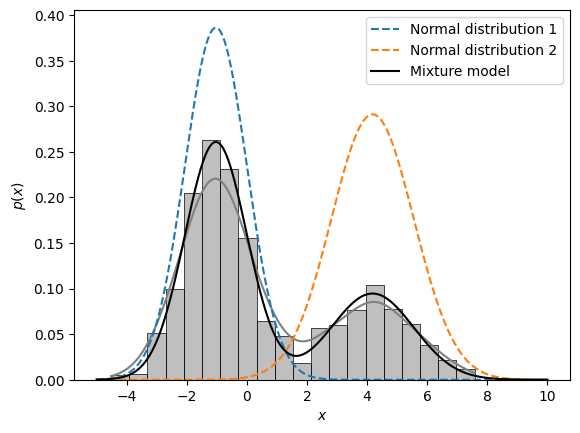

In [13]:
plot_mixture(x, *final_dist_params)

## GMM in Scikit-Learn
<hr>
Scikit-Learn provides an implementation of Gaussian mixture model in the class `sklearn.mixture.GaussianMixture.` Important parameters of this class include:

- `n_components`: The number of mixture components (defaults to 1).
- `covariance_type`: The type of covariance parameters to use. Can be one of the following options:
    - `full`: Each component has its own covariance matrix.
    - `tied`: All components share the same covariance matrix.
    - `diag`: Each component has its own covariance matrix, which must be diagonal.
    - `spherical`: Each component has its own single variance.
- `tol`: The convergence threshold. The EM algorithm will stop when the average improvement of the log-likelihood falls below this threshold (defaults to 0.001).
- `max_iter`: The number of EM iterations to perform (defaults to 100).
- `n_init`: The number of random initializations to perform (defaults to 1).
- `init_params`: The method used to initialize the parameters of the model. Can take one of the following options:
    - `kmeans`: The parameters are initialized using k-means (the default).
    - `k-means++`: The parameters are initialized using k-means++.
    - `random`: The parameters are randomly initialized.
    - `random_from_data`: The initial means are randomly selected from the given data points.
    
In addition, this class provides the following attributes:
- `weights_`: The mixture weights.
- `means_`: The means of each component.
- `covariances_`: The covariance of each component.
- `converged_`: A Boolean indicating whether a convergence has been reached by the EM algorithm.
- `n_iter_`: The number of steps used by the EM to reach convergence.

In [14]:
from sklearn.datasets import make_blobs
from sklearn.mixture import GaussianMixture

In [15]:
X, y = make_blobs(n_samples=500, centers=[(0, 0), (4, 4)], random_state=0)

# Apply a linear transformation to make the blobs elliptical
transformation = [[0.6, -0.6], [-0.2, 0.8]]
X = np.dot(X, transformation) 

# Add another spherical blob
X2, y2 = make_blobs(n_samples=150, centers=[(-2, -2)], cluster_std=0.5, random_state=0)
X = np.vstack((X, X2))

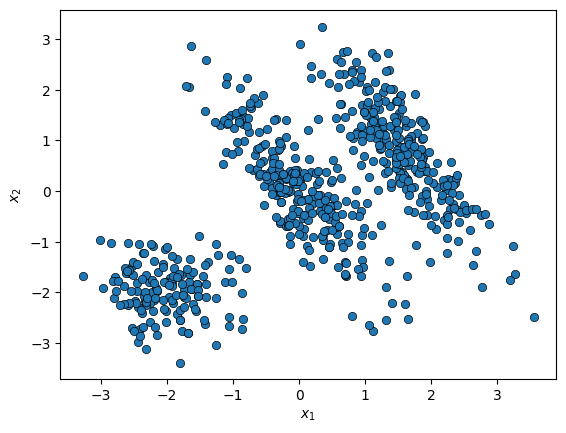

In [16]:
def plot_data(X):
    sns.scatterplot(x=X[:, 0], y=X[:, 1], edgecolor='k', legend=False)
    plt.xlabel('$x_1$')
    plt.ylabel('$x_2$')

plot_data(X)

In [22]:
gmm = GaussianMixture(n_components=3, init_params='k-means++')
labels = gmm.fit_predict(X)

In [23]:
print('Iterations:\n', gmm.n_iter_)
print('Weights:\n', gmm.weights_)
print('Means:\n', gmm.means_)
print('Covariances:\n', gmm.covariances_)

Iterations:
 12
Weights:
 [0.38468649 0.23077353 0.38453998]
Means:
 [[ 1.56396081  0.80286281]
 [-2.01578778 -1.95661972]
 [-0.03263972  0.03520845]]
Covariances:
 [[[ 0.35591964 -0.48205514]
  [-0.48205514  0.98323035]]

 [[ 0.2543165  -0.01588221]
  [-0.01588221  0.24474171]]

 [[ 0.41177693 -0.53089334]
  [-0.53089334  0.99973721]]]


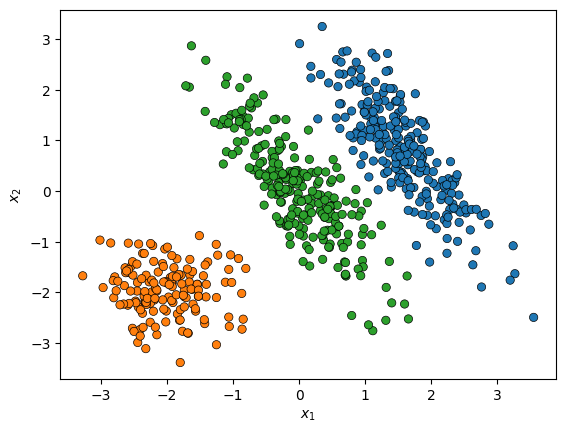

In [24]:
def plot_clusters(X, labels):    
    sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=labels, palette='tab10', edgecolor='k', legend=False)
    plt.xlabel('$x_1$')
    plt.ylabel('$x_2$')

plot_clusters(X, labels)

We can use the method `predict_proba()` to get the membership probabilities for each data point in each cluster. For instance, for the first point, it has a very high probability (almost 1) of belonging to one cluster.

In [25]:
prob = gmm.predict_proba(X)

In [26]:
print('x =', X[0])
print('prob =', prob[0])

x = [ 2.41692591 -0.07769481]
prob = [9.99999999e-01 3.11390689e-21 8.32174308e-10]


For comparison, the following figure shows the results of other clustering algorithms applied to the same dataset:

<div style="align:center">
    <img src="media/GMM_comparison.png">
</div>